This notebook shows how to use [CDD](https://www.inf.ethz.ch/personal/fukudak/cdd_home/) to compute controlled invariant sets for an hybrid system.
We consider the `cruise_control.jl` example of HybridSystems.jl which comes from [this paper](https://dl.acm.org/citation.cfm?id=2461378).

In [1]:
include(Pkg.dir("HybridSystems", "examples", "cruise_control.jl"));

In [2]:
const va = 15.6
const vb = 24.5
const vc = 29.5
const v = (va, vb, vc)
const U = 4.
const m0 = 500
const T = 2
const N = 10
const M = 1
const H = 0.8;

In [3]:
macro _time(x)
    quote
        y = @timed $(esc(x))
        # y[1] is returned value
        # y[2] is time in seconds
        y[2]
    end
end

@_time (macro with 1 method)

In [4]:
function liftu(S, sys::HybridSystems.DiscreteLinearControlSystem)
    [sys.A sys.B] \ S
end
function new_constraint(hs, S, q, t)
    @assert source(hs, t) == q
    σ = symbol(hs, t)
    r = target(hs, t)
    ABset = liftu(S[1], hs.resetmaps[σ])
    project(ABset, 1:statedim(hs, q))
end
function new_constraints(hs, S, q)
    map(t -> new_constraint(hs, S, q, t), out_transitions(hs, q))
end
function add_hrep!(S, h::HalfSpace)
    if S ⊆ h # If S ⊆ h, then adding h will not change affect S
        false
    else
        push!(S, SimpleHRepresentation(reshape(h.a, 1, length(h.a)), [h.β]))
        true
    end
end
function add_constraint!(S, P)
    added = count(map(h -> add_hrep!(S, h), ineqs(P))) + count(map(h -> add_hrep!(S, h), eqs(P)))
    removehredundancy!(S)
    added
end
function add_constraints!(S::Polyhedron, Ps::Vector{<:Polyhedron})
    sum(P -> add_constraint!(S, P), Ps)
end
function set_iteration!(hs, S)
    Ps = map(q -> new_constraints(hs, S, q), states(hs))
    added = add_constraints!.(S, Ps)
    @show added
end
function iterate!(hs, S, nit)
    map(i -> (@_time set_iteration!(hs, S)), 1:nit)
end

iterate! (generic function with 1 method)

In [10]:
Mmax = 1
nit = 7
t = zeros(Mmax, nit)
Hs = Vector{HybridSystem}(Mmax)
CIS = Vector{Vector{Polyhedron}}(Mmax)
for m in 1:Mmax
    Hs[m] = cruise_control_example(N, m, vmin = 5., v=(va, vb, vc), U=U, H=H, sym=false, m0=500);
    I0 = Hs[m].invariants;
    @show nineqs(I0[1])
    CIS[m] = deepcopy(I0);
    @show m
    t[m, :] = iterate!(Hs[m], CIS[m], nit)
    @show t[m, :]
end
t

nineqs(I0[1]) = 8
m = 1
added = [6, 8, 8, 8, 8, 8, 8, 8, 8, 8]
added = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
added = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
added = [14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
added = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
added = [26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
added = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
t[m, :] = [0.138743, 0.275568, 0.753732, 1.98394, 5.05119, 12.3602, 27.083]


1×7 Array{Float64,2}:
 0.138743  0.275568  0.753732  1.98394  5.05119  12.3602  27.083

In [6]:
import Plots
Plots.pyplot()

Plots.PyPlotBackend()


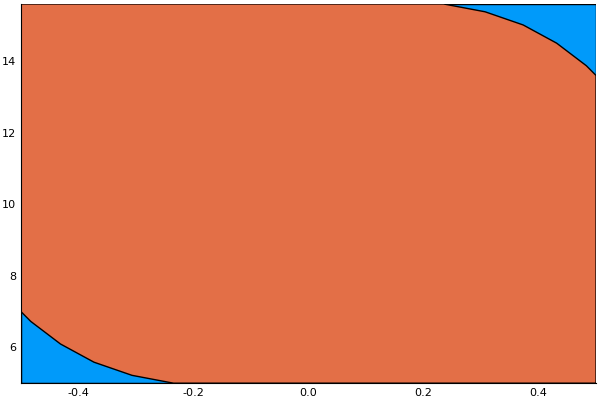

In [11]:
D = [1, 2]
Plots.plot(project(Hs[1].invariants[1], D))
Plots.plot!(project(CIS[1][1], D))

In [13]:
Plots.savefig("dist_trailerspeed.png")